In [1]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

#Number Manupulation & Plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tabula

#Model Selection Libraries
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

#Preprocessing Libraries
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

#Liner Model Libraries
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#pipeline libraries
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import sklearn
import sklearn.decomposition

from sklearn.svm import SVC
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df_teamDetail= pd.read_csv("Kabaddi-TeamDetailMetrics.csv")
df_teamDetail.drop(["BIGGEST WINNING MARGIN","HIGHEST SCORE","TOTAL DEFENCE POINTS"], inplace=True, axis=1)
df_teamDetail = df_teamDetail[~(df_teamDetail.Season == "OVERALL")]


cols = df_teamDetail.columns
raid = list(x for x in cols if "RAID" in x)
tackles = list(x for x in cols if "TACKLES" in x)
raid_tackles = raid + tackles
other = list(x for x in cols if  x not in raid_tackles)

In [3]:
#df_teamDetail.info()

In [4]:
print (df_teamDetail.shape)
#print (df_teamSum.shape)
#df_teamDetail.head()

(68, 23)


In [5]:
#df_team_merged.Metrics.unique()

In [6]:
df_teamDetail['TOTAL SUPER'] =  df_teamDetail['NO. OF SUPER RAIDS']+ df_teamDetail['NO. OF SUPER TACKLES']
cols_to_scale = list(df_teamDetail.select_dtypes(["int32","int64","float64"]).columns)
#Predict
Y= ["FINISHING POSITION", 'NO. OF SUPER RAIDS', 'NO. OF SUPER TACKLES', 'TOTAL SUPER',
'SUCCESSFUL RAIDS','SUCCESSFUL TACKLES']

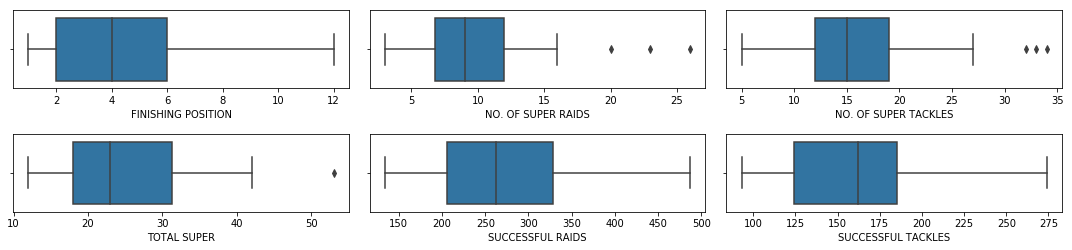

In [7]:
plt.figure(figsize=(15,10))
i=1
for pred in Y:
    plt.subplot(len(Y),3,i)
    sns.boxplot( df_teamDetail[pred])
    i+=1
plt.tight_layout()

#### Normalize Predicted Variables

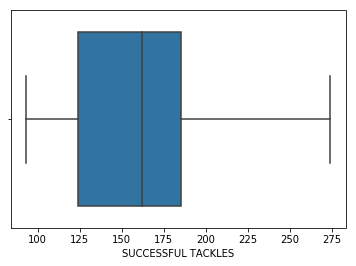

In [8]:
#sns.boxplot(np.log2(df_teamDetail['SUCCESSFUL TACKLES']))
sns.boxplot((df_teamDetail['SUCCESSFUL TACKLES']))

In [9]:
####Feature Engieering

df_teamDetail = df_teamDetail[np.log2(df_teamDetail['NO. OF SUPER TACKLES'])<5] # Remove Outlier

df_teamDetail['NO. OF SUPER RAIDS'] =  np.log2(df_teamDetail['NO. OF SUPER RAIDS'])
df_teamDetail['FINISHING POSITION'] =  np.log2(df_teamDetail['FINISHING POSITION'])
#df_teamDetail['SUCCESSFUL TACKLES'] =  np.log2(df_teamDetail['SUCCESSFUL TACKLES']) 
df_teamDetail['TOTAL SUPER']        =  np.log2(df_teamDetail['TOTAL SUPER'])

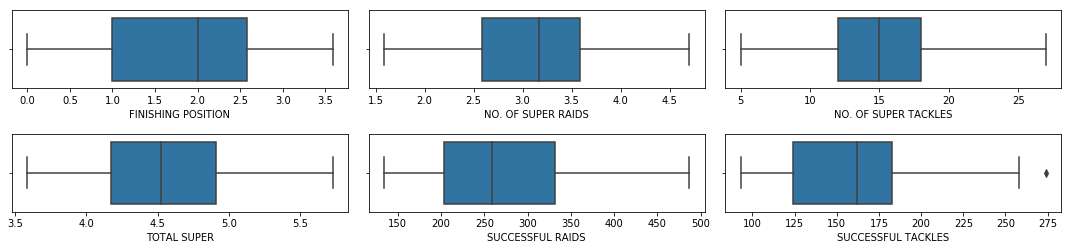

In [10]:
plt.figure(figsize=(15,10))
i=1
for pred in Y:
    plt.subplot(len(Y),3,i)
    sns.boxplot( df_teamDetail[pred])
    i+=1
plt.tight_layout()

#### Check Distribution Again

['MATCHES PLAYED', 'WINS', 'DRAWS', 'LOSSES', 'FINISHING POSITION', 'TOTAL RAIDS', 'SUCCESSFUL RAIDS', 'UNSUCCESSFUL RAID', 'EMPTY RAIDS', 'NO. OF SUPER RAIDS', 'RAID TOUCH POINTS', 'RAID BONUS POINTS', 'TOTAL RAID POINTS', 'TOTAL TACKLES', 'SUCCESSFUL TACKLES', 'UNSUCCESFUL TACKLES', 'NO. OF SUPER TACKLES', 'ALL OUTS INFLICTED', 'TOTAL ALL OUT POINTS', 'TOTAL SUPER']


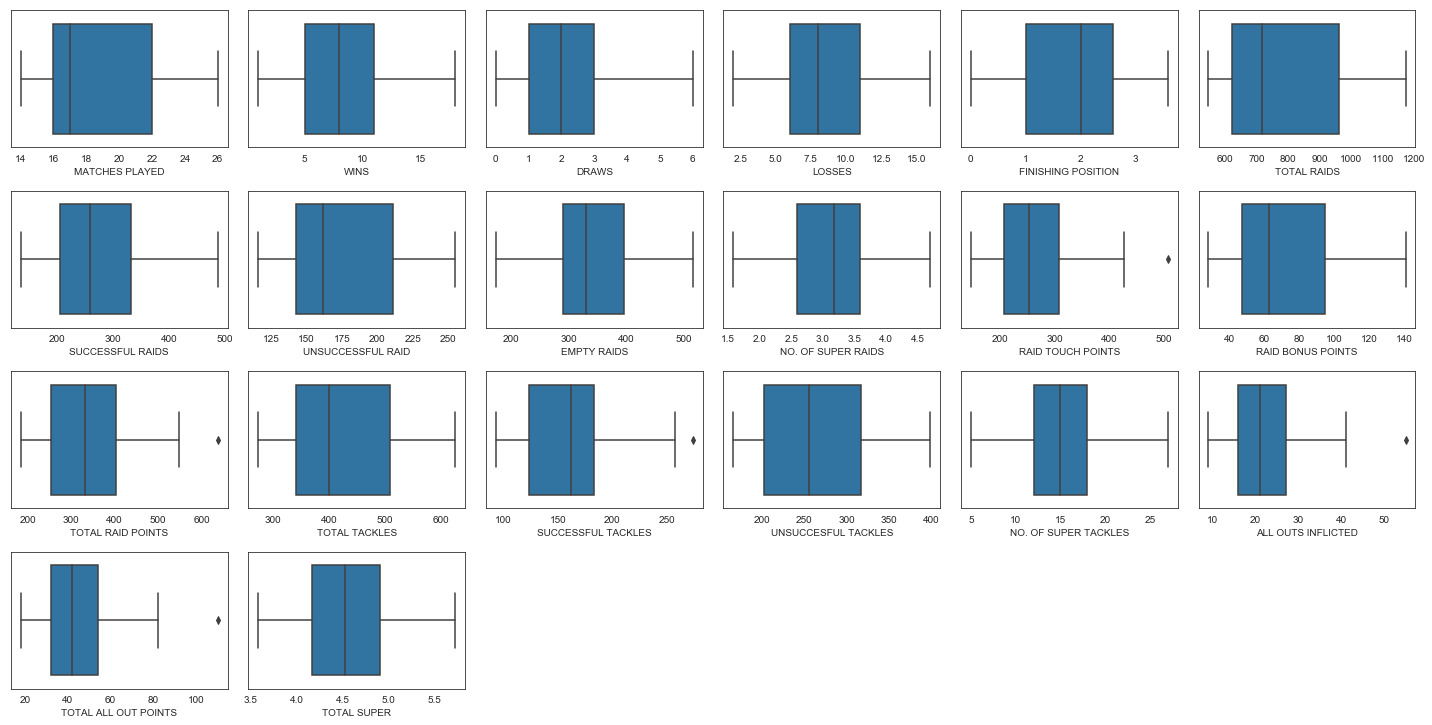

In [11]:
print (cols_to_scale)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_to_scale):
    plt.subplot(40,6,i)
    sns.boxplot( x=df_teamDetail[ cols_to_scale[i-1] ])
    i+=1
plt.tight_layout()
plt.show()

In [12]:
def get_train_validate_test_dataset(Metrics_Name):
    print ()
    if Metrics_Name=="":
        df_test2           = df_player_final [df_player_final.Season=="7"]
        df_player_Other    = df_player_final [df_player_final.Season!="7"]
        df_train, df_test1 = train_test_split(df_player_Other, test_size=.25, random_state=42)
        return df_train, df_test1, df_test2
    else:
        #df_team_merged_      = df_team_merged  [df_team_merged.Metrics == Metrics_Name]
        df_test2             = df_teamDetail [df_teamDetail.Season=="7"]
        df_team_Other = df_teamDetail [df_teamDetail.Season!="7"]
        df_train, df_test1 = train_test_split(df_team_Other, test_size=.25, random_state=42)
        #df_train, df_test1 = train_test_split(df_team_merged, test_size=.25, random_state=42)
    return df_train, df_test1, df_test2

In [13]:
def PredictMetrics(Metrics_Name):
    df_train, df_test1, df_test2 =  get_train_validate_test_dataset (Metrics_Name)

    #Scale Data
    sc = StandardScaler()
    df_train[cols_to_scale] = sc.fit_transform(df_train[cols_to_scale])
    df_test1[cols_to_scale] = sc.transform(df_test1[cols_to_scale])
    df_test2[cols_to_scale] = sc.transform(df_test2[cols_to_scale])

    y_train = df_train.pop(Metrics_Name)

    X_df_train = df_train

    y_test1 = df_test1.pop(Metrics_Name)
    X_df_test1 = df_test1

    y_test2 = df_test2.pop(Metrics_Name)
    X_df_test2 = df_test2

    ##Prepare Model
    #lr = LogisticRegression()
    lnr = LinearRegression()
    
    cols=cols_to_scale.copy()
    cols.remove(Metrics_Name)
    
    lnr.fit(X_df_train[cols],y_train)

    y_test1_pred = lnr.predict(X_df_test1[cols])

    y_test2_pred = lnr.predict(X_df_test2[cols])

    ##Prediction
    pred_total_score = pd.DataFrame({"Season": X_df_test1.Season,
                                     "Team":X_df_test1.Team,
                                     "Prediction":2**y_test1_pred,
                                     "Actual":2**y_test1})
    pred_total_score = pred_total_score.sort_values("Prediction", ascending=True)
    print("Prediction Results on Test Data", Metrics_Name)
    print("r2 score : ", round(metrics.r2_score(y_test1,y_test1_pred),2))
    print(pred_total_score)
    

    pred_total_score = pd.DataFrame({"Season": X_df_test2.Season,
                                     "Team":X_df_test2.Team,
                                     "Prediction": 2**y_test2_pred,                                                             
                                     "Actual":    2**y_test2 
                                    })
    pred_total_score = pred_total_score.sort_values("Prediction", ascending=True)
    print("\nPrediction Results for Season 7", Metrics_Name)
    print("r2 score : ", round(metrics.r2_score(y_test2,y_test2_pred),2))
    print(pred_total_score)

In [14]:
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (Y[0])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
PredictMetrics(Y[0])


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)



C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Prediction Results on Test Data FINISHING POSITION
r2 score :  0.69
   Season                  Team  Prediction    Actual
73      3              U Mumbai    0.391372  0.283585
78      6           U.P. Yoddha    0.745703  0.922577
66      2       Bengaluru Bulls    0.795373  0.922577
32      4         Patna Pirates    0.892658  0.283585
72      4              U Mumbai    1.002726  1.256489
22      2         Telugu Titans    1.017972  0.596926
30      6         Patna Pirates    1.091084  1.256489
10      6      Haryana Steelers    1.264954  1.941963
14      6       Tamil Thalaivas    1.455168  1.941963
21      3         Telugu Titans    1.489993  1.596681
50      2  Jaipur Pink Panthers    1.686024  1.596681
7       1     Dabang Delhi K.C.    1.812432  1.941963
42      2         Puneri Paltan    2.729897  2.644824
5       3     Dabang Delhi K.C.    3.044894  2.644824

Prediction Results for Season 7 FINISHING POSITION
r2 score :  0.63
   Season                   Team  Prediction    Actua

In [15]:
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (Y[1])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
PredictMetrics(Y[1])


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)



C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Prediction Results on Test Data NO. OF SUPER RAIDS
r2 score :  0.83
   Season                  Team  Prediction    Actual
72      4              U Mumbai    0.241826  0.269845
21      3         Telugu Titans    0.268243  0.175153
73      3              U Mumbai    0.334193  0.625506
7       1     Dabang Delhi K.C.    0.336061  0.377314
50      2  Jaipur Pink Panthers    0.486756  0.377314
32      4         Patna Pirates    0.508070  0.625506
5       3     Dabang Delhi K.C.    0.574950  0.377314
14      6       Tamil Thalaivas    0.792707  0.625506
42      2         Puneri Paltan    0.793070  0.764458
66      2       Bengaluru Bulls    0.815532  1.068912
78      6           U.P. Yoddha    0.971952  1.068912
10      6      Haryana Steelers    1.154805  1.405713
30      6         Patna Pirates    1.176686  1.233464
22      2         Telugu Titans    2.421125  2.165673

Prediction Results for Season 7 NO. OF SUPER RAIDS
r2 score :  0.74
   Season                   Team  Prediction    Actua

In [16]:
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (Y[2])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
PredictMetrics(Y[2])


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)



C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Prediction Results on Test Data NO. OF SUPER TACKLES
r2 score :  0.91
   Season                  Team  Prediction    Actual
73      3              U Mumbai    0.183966  0.302350
66      2       Bengaluru Bulls    0.317953  0.345584
7       1     Dabang Delhi K.C.    0.463439  0.516041
72      4              U Mumbai    0.557194  0.589832
42      2         Puneri Paltan    0.608643  0.589832
10      6      Haryana Steelers    0.982475  1.006705
5       3     Dabang Delhi K.C.    1.058209  0.770575
14      6       Tamil Thalaivas    1.123501  1.006705
30      6         Patna Pirates    1.152550  1.150657
22      2         Telugu Titans    1.238032  1.150657
21      3         Telugu Titans    1.368470  1.006705
50      2  Jaipur Pink Panthers    1.728273  1.503255
32      4         Patna Pirates    3.159511  5.005236
78      6           U.P. Yoddha    3.900829  5.005236

Prediction Results for Season 7 NO. OF SUPER TACKLES
r2 score :  0.85
   Season                   Team  Prediction    A

In [17]:
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (Y[3])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
PredictMetrics(Y[3])


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)



C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Prediction Results on Test Data TOTAL SUPER
r2 score :  0.94
   Season                  Team  Prediction    Actual
73      3              U Mumbai    0.377644  0.254598
72      4              U Mumbai    0.378811  0.348093
7       1     Dabang Delhi K.C.    0.379340  0.348093
21      3         Telugu Titans    0.404927  0.518522
5       3     Dabang Delhi K.C.    0.424245  0.518522
66      2       Bengaluru Bulls    0.520599  0.457624
42      2         Puneri Paltan    0.571524  0.583567
50      2  Jaipur Pink Panthers    0.760125  0.886039
14      6       Tamil Thalaivas    0.761402  0.804001
30      6         Patna Pirates    1.297366  1.257941
10      6      Haryana Steelers    1.423790  1.257941
22      2         Telugu Titans    1.580577  1.823641
32      4         Patna Pirates    2.334444  2.082036
78      6           U.P. Yoddha    3.007266  2.504699

Prediction Results for Season 7 TOTAL SUPER
r2 score :  0.91
   Season                   Team  Prediction    Actual
13      7   

In [18]:
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (Y[4])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
PredictMetrics(Y[4])


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)



C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Prediction Results on Test Data SUCCESSFUL RAIDS
r2 score :  1.0
   Season                  Team  Prediction    Actual
42      2         Puneri Paltan    0.450624  0.450624
5       3     Dabang Delhi K.C.    0.454204  0.454204
50      2  Jaipur Pink Panthers    0.499440  0.499440
72      4              U Mumbai    0.519594  0.519594
66      2       Bengaluru Bulls    0.544854  0.544854
73      3              U Mumbai    0.599120  0.599120
32      4         Patna Pirates    0.599120  0.599120
21      3         Telugu Titans    0.599120  0.599120
7       1     Dabang Delhi K.C.    0.822161  0.822161
22      2         Telugu Titans    0.955526  0.955526
14      6       Tamil Thalaivas    1.785226  1.785226
78      6           U.P. Yoddha    1.978620  1.978620
10      6      Haryana Steelers    2.042239  2.042239
30      6         Patna Pirates    2.915617  2.915617

Prediction Results for Season 7 SUCCESSFUL RAIDS
r2 score :  1.0
   Season                   Team  Prediction    Actual
77  

In [19]:
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (Y[5])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
PredictMetrics(Y[5])


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)



C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Prediction Results on Test Data SUCCESSFUL TACKLES
r2 score :  1.0
   Season                  Team  Prediction    Actual
5       3     Dabang Delhi K.C.    0.376980  0.376980
21      3         Telugu Titans    0.394020  0.394020
42      2         Puneri Paltan    0.411830  0.411830
72      4              U Mumbai    0.449903  0.449903
50      2  Jaipur Pink Panthers    0.552992  0.552992
7       1     Dabang Delhi K.C.    0.552992  0.552992
32      4         Patna Pirates    0.753563  0.753563
66      2       Bengaluru Bulls    0.912683  0.912683
22      2         Telugu Titans    0.912683  0.912683
73      3              U Mumbai    0.982472  0.982472
14      6       Tamil Thalaivas    1.155368  1.155368
10      6      Haryana Steelers    1.262178  1.262178
30      6         Patna Pirates    1.378861  1.378861
78      6           U.P. Yoddha    3.055780  3.055780

Prediction Results for Season 7 SUCCESSFUL TACKLES
r2 score :  1.0
   Season                   Team  Prediction    Actual


<font size=6, color=red>Creating Player Dataset from pdf files</font>

In [20]:
folders = ["Bangalore","Delhi","Bengal"]
folders = ["Bangalore"]

In [21]:
#Convert all pds files in CSV
for folder in folders:
    print(folder)
    files=os.listdir("players\\"+folder)
    for f in files:
        f1 = f.split(".")
        print ("players\\folder\\"+f1[0]+".csv")
        
        if f1[1]=="pdf":
            tabula.convert_into("players\\"+folder+"\\"+f, "players\\"+folder+"\\"+f1[0]+".csv", output_format="csv")

Bangalore
players\folder\ajay-profile-2353.csv
players\folder\ajay-profile-2353.csv
players\folder\aman-profile-2501.csv
players\folder\aman-profile-2501.csv
players\folder\amit-sheoran-profile-794.csv
players\folder\amit-sheoran-profile-794.csv
players\folder\ankit-profile-2471.csv
players\folder\ankit-profile-2471.csv
players\folder\ashish-kumar-profile-202.csv
players\folder\ashish-kumar-profile-202.csv
players\folder\banty-profile-2503.csv
players\folder\banty-profile-2503.csv
players\folder\lbanty-profile-2503.csv
players\folder\lbanty-profile-2503.csv
players\folder\mahender-singh-profile-769.csv
players\folder\mahender-singh-profile-769.csv
players\folder\mohit-sehrawat-profile-2502.csv
players\folder\mohit-sehrawat-profile-2502.csv
players\folder\pawan-sehrawat-profile-318.csv
players\folder\pawan-sehrawat-profile-318.csv
players\folder\raju-lal-choudhary-profile-87.csv
players\folder\raju-lal-choudhary-profile-87.csv
players\folder\rohit-kumar-profile-326.csv
players\folder\ro

In [121]:
def massage_ds(df1):
    df1.SEASONS [df1.SEASONS=="EARNED"] ="TOTAL POINTS EARNED"
    df1.SEASONS [ (df1.SEASONS=="MATCH") & (df1.index<6) ] = "MOST POINTS IN A MATCH"
    df1.SEASONS [df1.SEASONS=="MATCH"] = "AVERAGE TACKLE / MATCH"
    df1.SEASONS [df1.SEASONS=="%"] = "SUCCESSFUL RAIDS %"
    df1.SEASONS [df1.SEASONS=="POINTS / MATCH"] = "AVERAGE RAID POINTS / MATCH"
    df1.SEASONS [df1.SEASONS=="TACKLES"] = "NO OF SUPER TACKLES"
    df1.SEASONS [df1.SEASONS=="POINTS"] = "TOTAL TACKLE POINTS"
    df1.SEASONS [df1.SEASONS=="TACKLE STRIKE RATE"] ="TACKLE STRIKE RATE %"
    df1=df1[~df1.OVERALL.isna()]
    return df1

In [122]:
### Read all CSV files into dataset. Massage all dataset. Put datasets in array datasets
dfs=[]
for folder in folders:
    print(folder)
    files=os.listdir("players\\"+folder)
    for f in files:
        f1 = f.split(".")
      
        if f1[1]=="csv":
            file="players\\"+folder+"\\"+f1[0]+".csv"
            
            print(file)
            df= pd.read_csv(file)
            df = massage_ds(df)
            
            df["Player"]=f1[0]
            df["Team"]=folder
            
            dfs.append(df)

Bangalore
players\Bangalore\ajay-profile-2353.csv
players\Bangalore\aman-profile-2501.csv
players\Bangalore\amit-sheoran-profile-794.csv
players\Bangalore\ankit-profile-2471.csv
players\Bangalore\ashish-kumar-profile-202.csv
players\Bangalore\banty-profile-2503.csv
players\Bangalore\lbanty-profile-2503.csv
players\Bangalore\mahender-singh-profile-769.csv
players\Bangalore\mohit-sehrawat-profile-2502.csv
players\Bangalore\pawan-sehrawat-profile-318.csv
players\Bangalore\raju-lal-choudhary-profile-87.csv
players\Bangalore\rohit-kumar-profile-326.csv
players\Bangalore\sandeep-profile-299.csv
players\Bangalore\sanjay-shrestha-profile-15.csv
players\Bangalore\saurabh-nandal-profile-2670.csv
players\Bangalore\sumit-singh-profile-363.csv
players\Bangalore\vijay-kumar-profile-768.csv
players\Bangalore\vinod-kumar-profile-387.csv


In [123]:
###Merge All Datasets
First=True
for d in dfs:
    if First:
        df=d
        First=False
    else: 
        df = pd.concat([df, d])
        
df.drop(columns=["Unnamed: 4","Unnamed: 5","Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 9"], inplace=True)

In [147]:
#Reduce Dataset Columns Season 1, Season 2 etc to Season.
col1= ['Player', 'SEASONS', 'Team']
i=1
while i<=7:
    s="SEASON "+str(i)
    col2=col1.copy()
    col2.append(s)
    if i==1:
        df2 = df[col2]
        df2= df2.rename(columns = { s : "Score"})
        df2['Season']=i

    else:
        df_temp=df[col2]
        df_temp= df_temp.rename(columns = { s : "Score"})
        df_temp['Season']=i
        
        df2 = pd.concat( [df2, df_temp ], axis=0)
    i+=1

In [148]:
#Transform the final dataset
df2=df2[~df2.Score.isna()]

df2= df2.rename(columns = { "SEASONS" : "Metrics"})
df2.index = np.arange(len(df2))
df2[ ['Score','Junk'] ] = df2.Score.str.split(" ", expand=True)
df2.Metrics = df2.Metrics.str.replace("?","")
df2.drop(columns="Junk", inplace=True)

df2=df2[~df2.Score.isna()]

In [168]:
df2.head()

,Player,Metrics,Team,Score,Season
0,raju-lal-choudhary-profile-87,MATCHES PLAYED,Bangalore,5,1
1,raju-lal-choudhary-profile-87,TOTAL POINTS EARNED,Bangalore,2,1
2,raju-lal-choudhary-profile-87,MOST POINTS IN A MATCH,Bangalore,2,1
3,raju-lal-choudhary-profile-87,NOT OUT %,Bangalore,0,1
4,raju-lal-choudhary-profile-87,TOTAL RAIDS,Bangalore,0,1


In [169]:
df2.shape

(688, 5)